# Linearity measure applied to fashion MNIST
* We train a convolutional neural network to classify the images in the fashion MNIST dataset. 

* We investigate the correlation between the model's linearity associated to a certain instance and the class the instance belong to. 

* We also calculate the linearity measure for each internal layer of the CNN and show how linearity propagates through the model.

In [1]:
import pandas as pd
import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from time import time

import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)  # suppress deprecation messages

from alibi.confidence.model_linearity import linearity_measure, LinearityMeasure
from alibi.confidence.model_linearity import _infer_feature_range

import keras
from keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Input, Activation
from keras.models import Model
from keras.utils import to_categorical
from keras import backend as K

Using TensorFlow backend.


## Load data fashion mnist 
The fashion MNIST data set consists of 60000 images of shape $28 \times 28$ divided in 10 categories. Each category corresponds to a different type of clothing piece, such as "boots", "t-shirts", etc

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
print('x_train shape:', x_train.shape, 'y_train shape:', y_train.shape)

x_train shape: (60000, 28, 28) y_train shape: (60000,)


Sample instance from the MNIST data set.


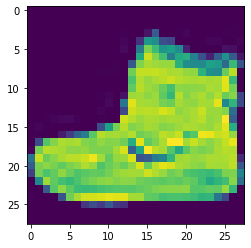

In [3]:
idx = 0
plt.imshow(x_train[idx])
print('Sample instance from the MNIST data set.')

In [4]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_train = np.reshape(x_train, x_train.shape + (1,))
x_test = np.reshape(x_test, x_test.shape + (1,))
print('x_train shape:', x_train.shape, 'x_test shape:', x_test.shape)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print('y_train shape:', y_train.shape, 'y_test shape:', y_test.shape)

x_train shape: (60000, 28, 28, 1) x_test shape: (10000, 28, 28, 1)
y_train shape: (60000, 10) y_test shape: (10000, 10)


## Convolutional neural network
Here we define and train a 2 layer convolutional neural network on the fashion MNIST data set.

### Define model

In [5]:
def model():
    x_in = Input(shape=(28, 28, 1), name='input')
    x = Conv2D(filters=64, kernel_size=2, padding='same', name='conv_1')(x_in)
    x = Activation('relu', name='relu_1')(x)
    x = MaxPooling2D(pool_size=2, name='maxp_1')(x)
    x = Dropout(0.3, name='drop_1')(x)
    
    x = Conv2D(filters=64, kernel_size=2, padding='same', name='conv_2')(x)
    x = Activation('relu', name='relu_2')(x)
    x = MaxPooling2D(pool_size=2, name='maxp_2')(x)
    x = Dropout(0.3, name='drop_2')(x)
    
    x = Flatten(name='flat')(x)
    x = Dense(256, name='dense_1')(x)
    x = Activation('relu', name='relu_3')(x)
    x = Dropout(0.5, name='drop_3')(x)
    x_out = Dense(10, name='dense_2')(x)
    x_out = Activation('softmax', name='softmax')(x_out)
    
    cnn = Model(inputs=x_in, outputs=x_out)
    cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return cnn

In [6]:
cnn = model()
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 28, 28, 1)         0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 28, 28, 64)        320       
_________________________________________________________________
relu_1 (Activation)          (None, 28, 28, 64)        0         
_________________________________________________________________
maxp_1 (MaxPooling2D)        (None, 14, 14, 64)        0         
_________________________________________________________________
drop_1 (Dropout)             (None, 14, 14, 64)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 14, 14, 64)        16448     
_________________________________________________________________
relu_2 (Activation)          (None, 14, 14, 64)        0         
__________

### Training

In [7]:
cnn.fit(x_train, y_train, batch_size=64, epochs=3);

Epoch 1/3
60000/60000 [==============================] - 47s 776us/step - loss: 0.5560 - acc: 0.7969
Epoch 2/3
60000/60000 [==============================] - 50s 829us/step - loss: 0.3816 - acc: 0.8621
Epoch 3/3
60000/60000 [==============================] - 46s 771us/step - loss: 0.3406 - acc: 0.8761


## Linearity of each Layer 
Here we calculate the linearity of the model considering each layer as the output in turn. The values are averaged over 100 random instances sampled from the training set.

### Extract layers

In [8]:
inp = cnn.input
outs = {l.name: l.output for l in cnn.layers}
predict_fns = {name: K.function([inp], [out]) for name, out in outs.items()}

### Calculate linearity

In [9]:
# Infering feature ranges.
features_range = _infer_feature_range(x_train)

# Selecting random instances from training set.
rnd = np.random.randint(len(x_train) - 1001, size=100)

In [10]:
lins_layers = {}
for name, l in predict_fns.items():
    if name != 'input':
        def predict_fn(x):
            layer = l([x])
            return layer[0]
        if name == 'softmax':
            lins_layers[name] = linearity_measure(predict_fn, x_train[rnd], features_range=features_range,
                                                  agg='global', model_type='classifier', nb_samples=10)
        else:
            lins_layers[name] = linearity_measure(predict_fn, x_train[rnd], features_range=features_range, 
                                                  agg='global', model_type='regressor', nb_samples=10)
lins_layers_mean = {k: v.mean() for k, v in lins_layers.items()}
S = pd.Series(data=lins_layers_mean)

Linearity measure in the locality of a given instance calculated taking as output each layer of a convolutional neural network trained on the fashion MNIST data set.


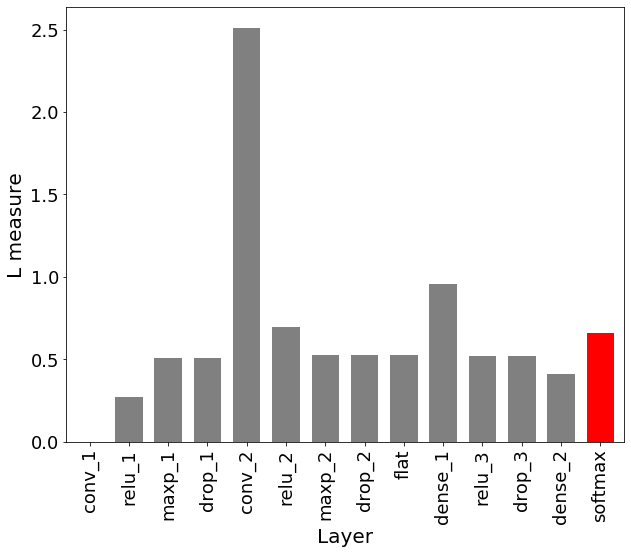

In [11]:
colors = ['gray' for l in S[:-1]]
colors.append('r')
ax = S.plot(kind='bar', linewidth=3, figsize=(10,8), color=colors, width=0.7, fontsize=18)
ax.set_ylabel('L measure', fontsize=20)
ax.set_xlabel('Layer', fontsize=20)
print('Linearity measure in the locality of a given instance calculated taking as output each layer of a convolutional neural network trained on the fashion MNIST data set.')

## Linearity and categories
Here we calculate the linearity averaged over all instances belonging to the same class, for each class.

In [12]:
class_groups = []
for i in range(10):
    y = y_train.argmax(axis=1)
    idxs_i = np.where(y == i)[0]
    class_groups.append(x_train[idxs_i])

In [13]:
def predict_fn(x):
    return cnn.predict(x)
lins_classes = []
t_0 = time()
for j in range(len(class_groups)):
    print('Calculating linearity for instances belonging to class {}'.format(j))
    class_group = class_groups[j]
    class_group = np.random.permutation(class_group)[:2000]
    t_i = time()
    lin = linearity_measure(predict_fn, class_group, features_range=features_range,
                                                  agg='global', model_type='classifier', nb_samples=20)
    t_i_1 = time() - t_i
    print('Run time for class {}: {}'.format(j, t_i_1))
    lins_classes.append(lin)
t_fin = time() - t_0
print('Total run time: {}'.format(t_fin))

Calculating linearity for instances belonging to class 0
Run time for class 0: 6.381826400756836
Calculating linearity for instances belonging to class 1
Run time for class 1: 6.049623727798462
Calculating linearity for instances belonging to class 2
Run time for class 2: 5.355603456497192
Calculating linearity for instances belonging to class 3
Run time for class 3: 5.366581916809082
Calculating linearity for instances belonging to class 4
Run time for class 4: 5.388520002365112
Calculating linearity for instances belonging to class 5
Run time for class 5: 6.289607286453247
Calculating linearity for instances belonging to class 6
Run time for class 6: 6.15662407875061
Calculating linearity for instances belonging to class 7
Run time for class 7: 6.113213539123535
Calculating linearity for instances belonging to class 8
Run time for class 8: 6.077864170074463
Calculating linearity for instances belonging to class 9
Run time for class 9: 6.1174468994140625
Total run time: 59.34823727607

In [14]:
df = pd.DataFrame(data=lins_classes).T

Linearity measure distribution means for each class in the fashion MNIST data set.


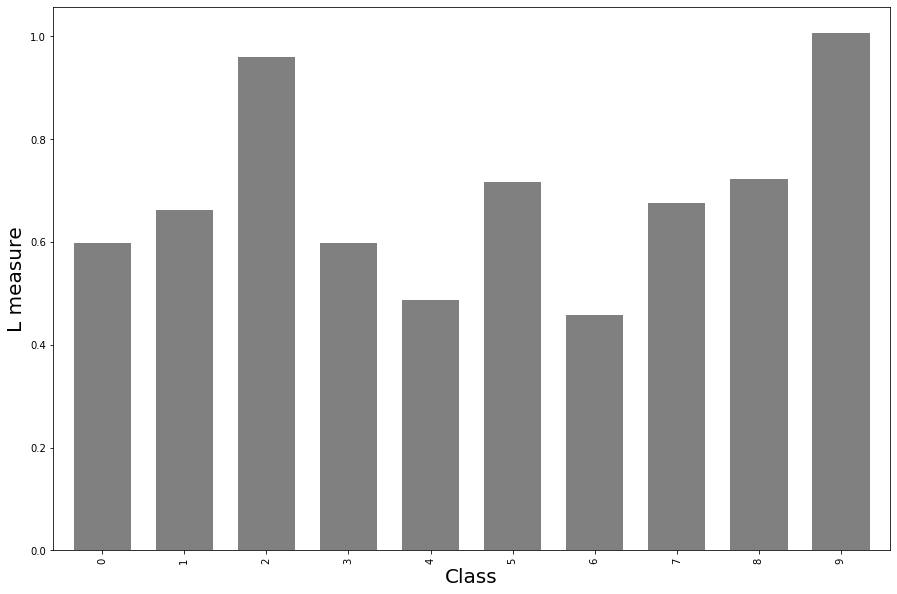

In [15]:
ax = df.mean().plot(kind='bar', linewidth=3, figsize=(15,10), color='gray', width=0.7, fontsize=10)
ax.set_ylabel('L measure', fontsize=20)
ax.set_xlabel('Class', fontsize=20)
print("Linearity measure distribution means for each class in the fashion MNIST data set.")

Linearity measure distributions for each class in the fashion MNIST data set.


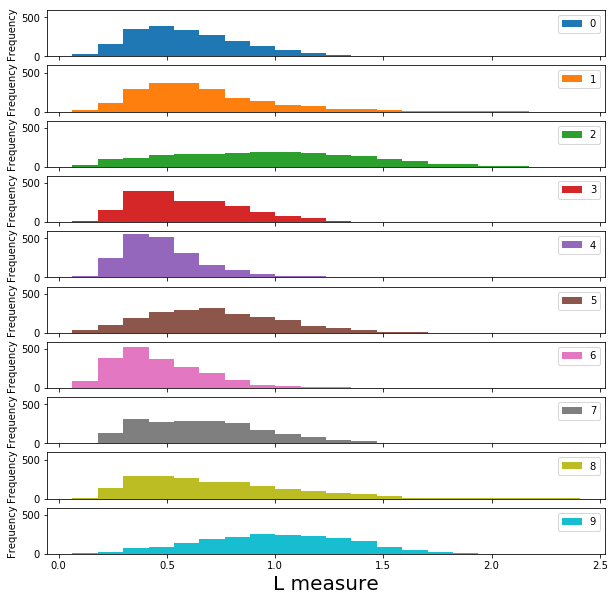

In [16]:
ax2 = df.plot(kind='hist', subplots=True, bins=20, figsize=(10,10), sharey=True)
for a in ax2:
    a.set_xlabel('L measure', fontsize=20)
#ax2.set_ylabel('F', fontsize=10)
print('Linearity measure distributions for each class in the fashion MNIST data set.')